In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import umap

from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp
from External.generation import create_graph

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

In [5]:
plt.style.use('standard.mplstyle')

# Hyperparameters
mode = "K_Nearest+Density"
metric = "euclidean"

In [6]:
labels = pd.read_csv("~/Data/pancreas/obs.csv",header=0)
position = pd.read_csv("~/Data/pancreas/X.csv",header=None)

mask = labels.index[(labels['day'] <= 15.5) & 
                    ((labels["clusters_fig6_broad_final"] == "Ngn3 low EP") |
                     (labels["clusters_fig6_broad_final"] == "Ngn3 high EP") |
                     (labels["clusters_fig6_broad_final"] == "Fev+") |
                     (labels["clusters_fig6_broad_final"] == 'Delta') | 
                     (labels["clusters_fig6_broad_final"] ==  'Alpha') | 
                     (labels["clusters_fig6_broad_final"] ==  'Epsilon') | 
                     (labels["clusters_fig6_broad_final"] ==  'Beta') )]

unique_labels = list(labels.loc[mask]["clusters_fig6_broad_final"].unique())
labels = labels.loc[mask]["clusters_fig6_broad_final"].to_numpy()

position = position.loc[mask].to_numpy()

number_of_nodes = len(position)

print(f"Number of nodes = {len(position)}")
print(f"Number of dimensions = {len(position[0])}")

Number of nodes = 10176
Number of dimensions = 3999


In [7]:
start = time.time()
number_of_nodes = len(position)
# Create the graph with the high D position array

pos = StandardScaler().fit_transform(position)
pca_100d = PCA(n_components=100).fit_transform(pos)

G, _ = create_graph(number_of_nodes, mode, position=pca_100d, beta=1.25)
G.indexEdges()

print(time.time()-start)

Final k: 11



17.160345315933228


In [8]:
# calculate the UMAP embedding. In the plots replace position with embedding

reducer = umap.UMAP(min_dist=0.8,random_state=42)
# scaled_data = StandardScaler().fit_transform(position)
scaled_data = position
embedding = reducer.fit_transform(scaled_data)

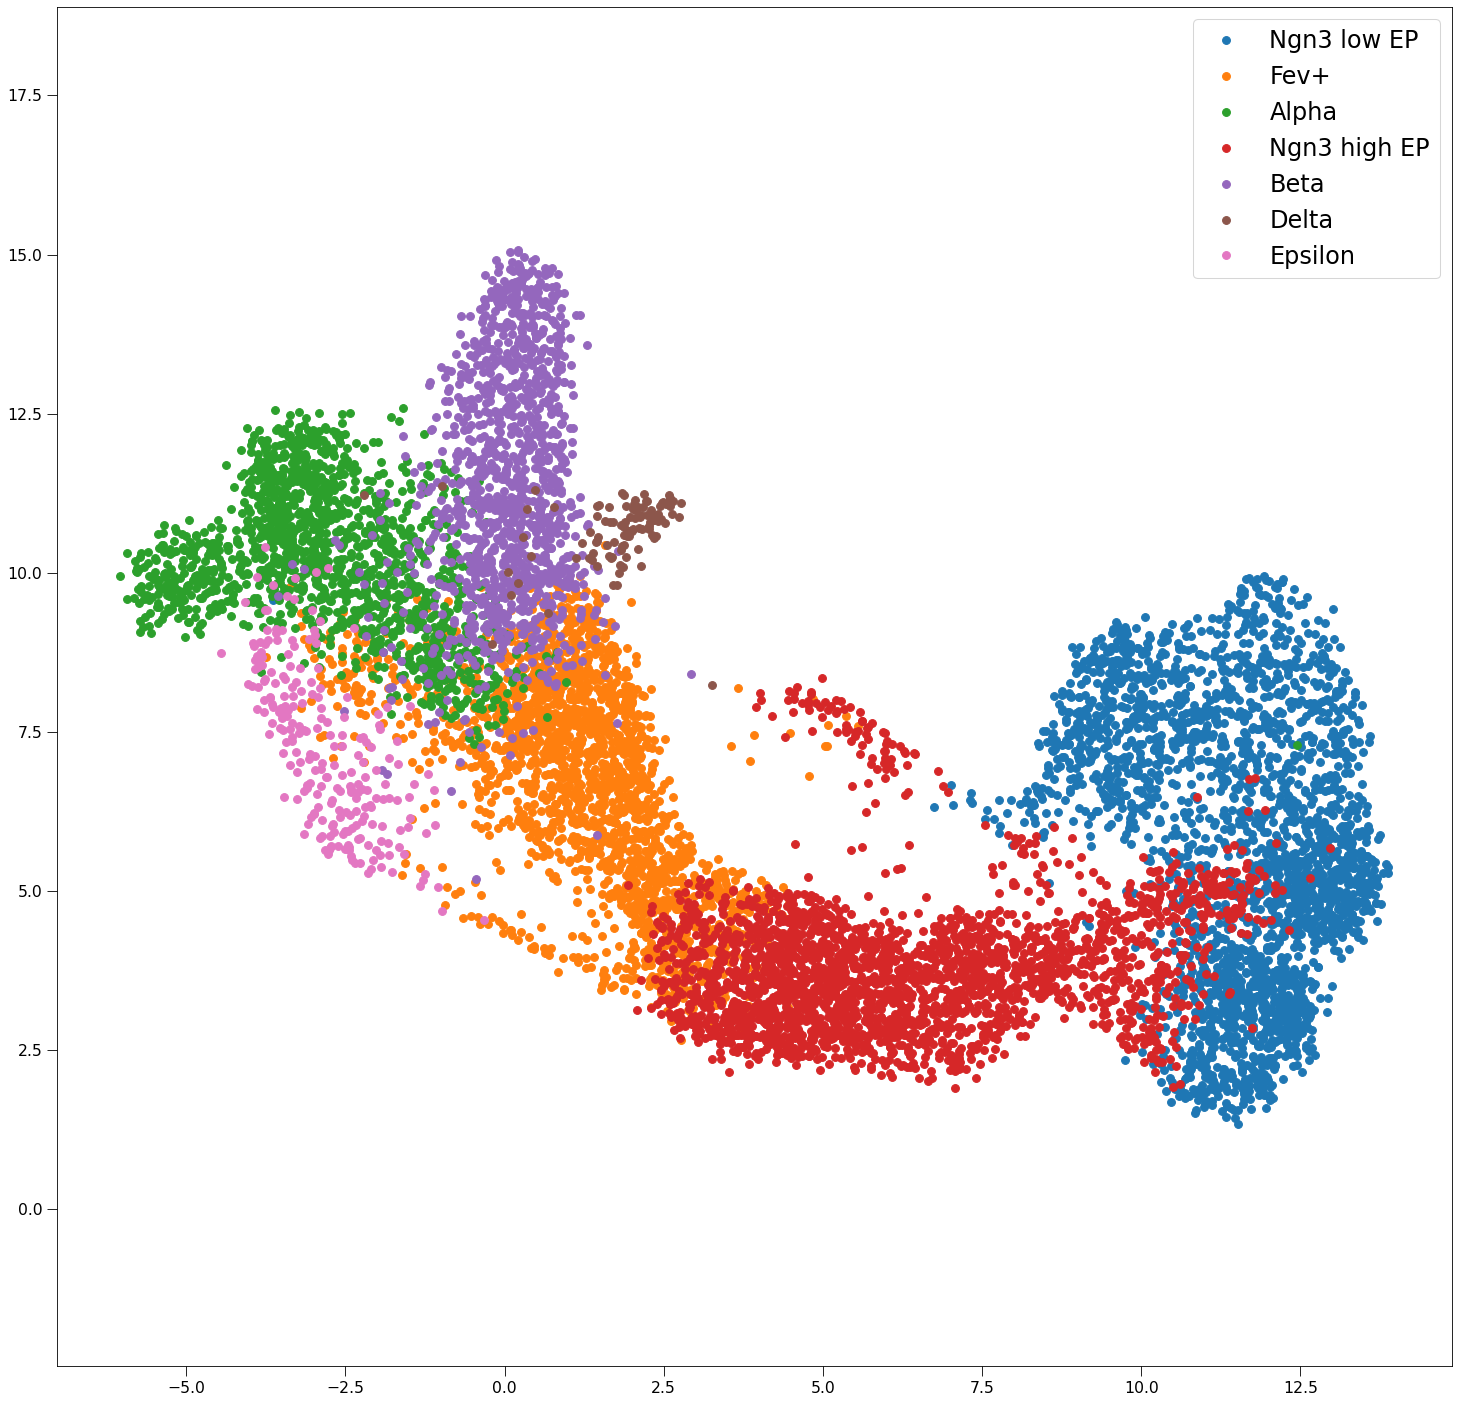

In [9]:
fig, ax = plt.subplots(1, figsize=(24,24))
for label in unique_labels:
    plt.plot(*embedding[np.argwhere(labels == label).T[0]].T, label=label)
ax.axis("equal")
plt.legend()
plt.show()

In [10]:
# calculate the clusters
ε, δ = 0.03, 0.1
r = 1 / (ε**2) * (int(np.log2(number_of_nodes - 1)) + 1 + np.log(1/δ))
k = int(np.sqrt(r))
k = np.min((k, G.numberOfNodes()))
cluster_centers = k_means_pp(k, position, metric=metric, G=G)

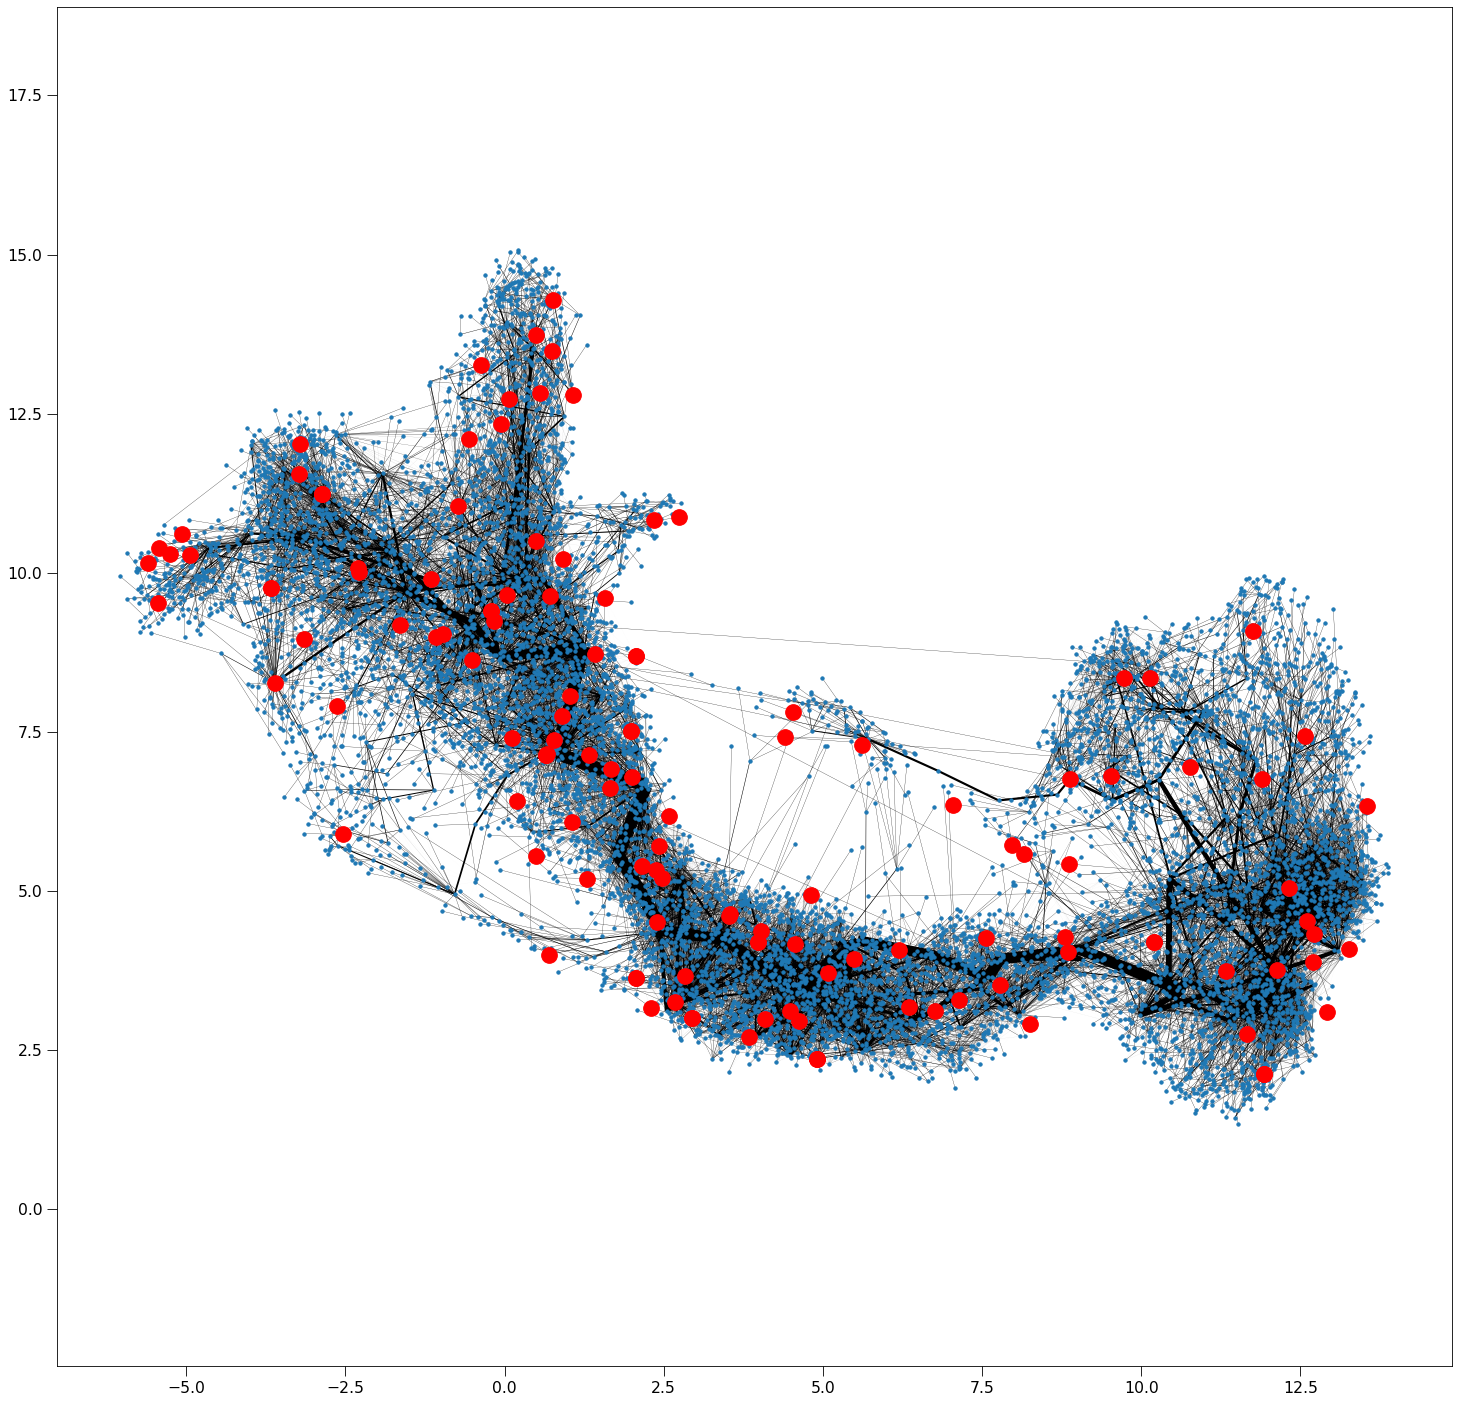

In [11]:
# plot the graph
fig, ax = plt.subplots(1, figsize=(24,24))
nk.viztasks.drawGraph(G, pos=embedding, ax=ax, width=compute_widths(G), node_size=10)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.plot(*embedding[cluster_centers].T, marker="o", color = "Red")
ax.set_axis_on()
ax.axis("equal")
plt.show()

## Cluster ICT

In [12]:
# calculate the cluster ICT with all aim nodes
start = time.time()
ICT_cluster_all = calculate_ICT(G, algorithm_type="cluster_all", cluster_centers=cluster_centers,
                                zeros_stay_zeros=True, update_G=1.1)
ICT_cluster_all.indexEdges()

# widths of the edges
widths_cluster_all = compute_widths(ICT_cluster_all)
print(time.time()-start)

update Arr 96612 -> 20086
added 5300 edges early
update Arr 20086 -> 18234
added 335 edges early
update Arr 18234 -> 16572
added 231 edges early
update Arr 16572 -> 15032
added 338 edges early
update Arr 15032 -> 13644
added 401 edges early
update Arr 13644 -> 12311
added 520 edges early
update Arr 12311 -> 11191
added 515 edges early
update Arr 11191 -> 10175
added 618 edges early
added 1701 edges early

70.4129102230072


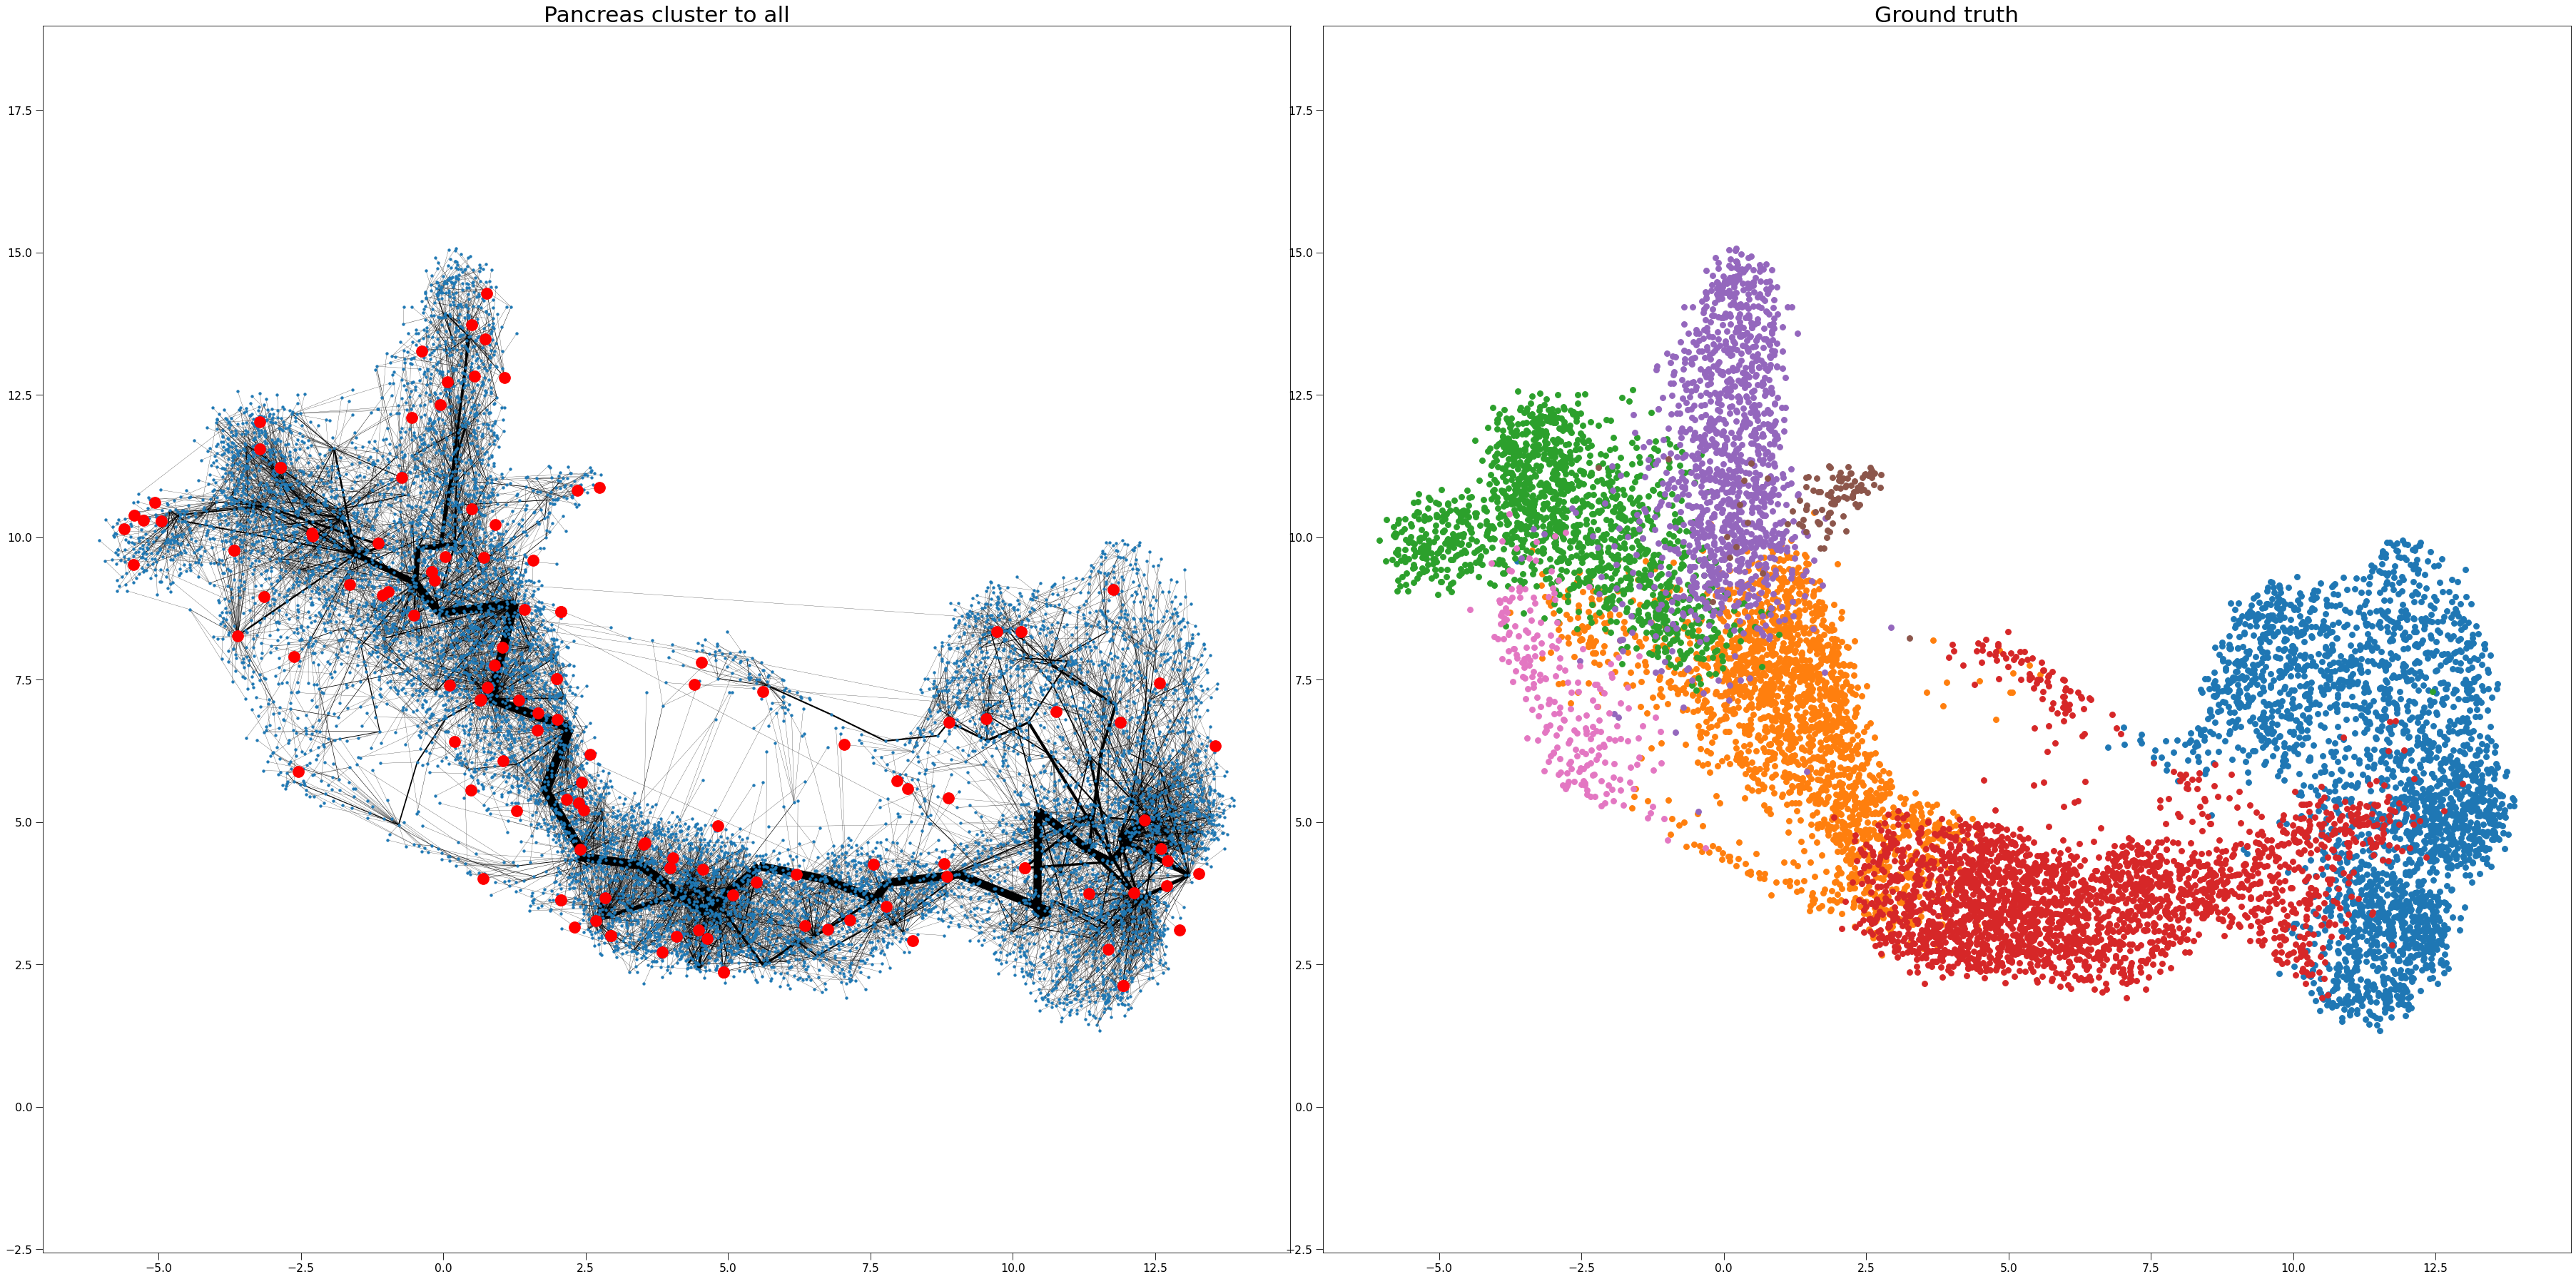

In [13]:
# plotting
graphs = [ICT_cluster_all]
widths = [widths_cluster_all]
names = ["Pancreas cluster to all", "Ground truth"]


number_of_plots = len(names)
fig, ax = plt.subplots(1,2, figsize=(24*2,24))

if number_of_plots == 1:
    ax = [ax]
    
for i in range(number_of_plots):
    if i == 0:
        nk.viztasks.drawGraph(graphs[i], pos=embedding, ax=ax[i], width=widths[i], node_size=10)
        ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax[i].plot(*embedding[cluster_centers].T, marker="o", color = "Red")
        ax[i].set_axis_on()
    else:
        for label in unique_labels:
            plt.plot(*embedding[np.argwhere(labels == label).T[0]].T, label=label)
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.tight_layout()
plt.savefig("./Output/Images/pancreas-11-1_25")
plt.show()

In [14]:
dtae_embedding = pd.read_csv("~/Data/pancreas/embedding.csv",header=None)

dtae_embedding = dtae_embedding.loc[mask]

dtae_embedding = dtae_embedding.to_numpy()

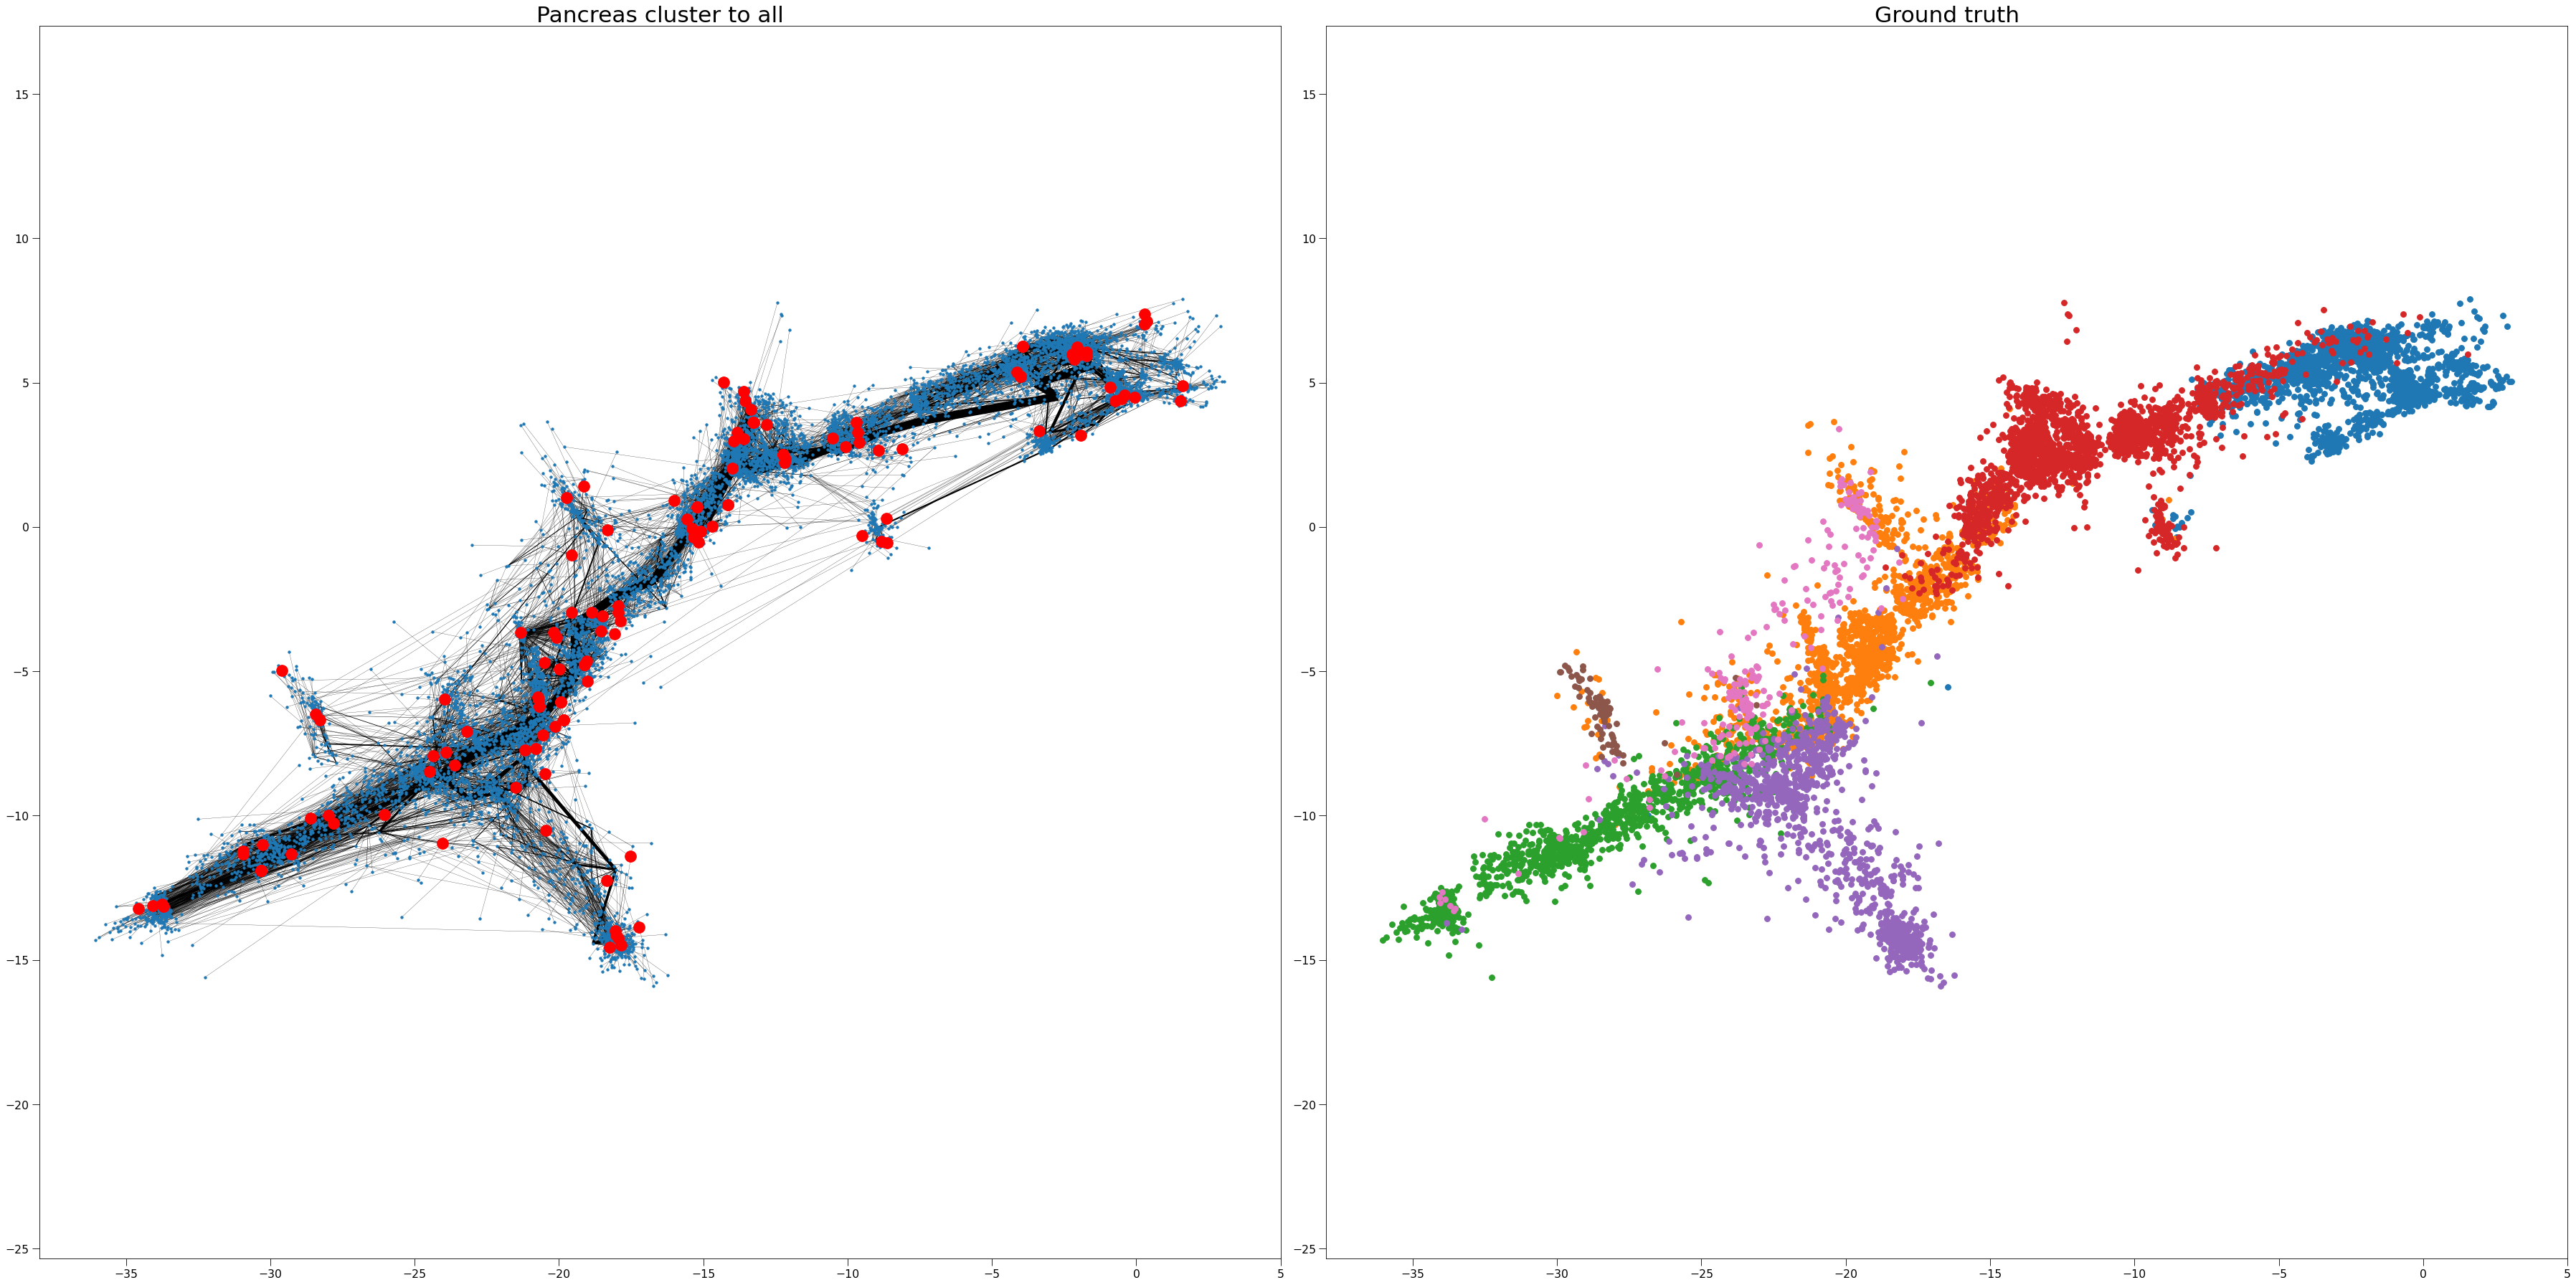

In [15]:
# plotting
graphs = [ICT_cluster_all]
widths = [widths_cluster_all]
names = ["Pancreas cluster to all", "Ground truth"]


number_of_plots = len(names)
fig, ax = plt.subplots(1,2, figsize=(24*2,24))

if number_of_plots == 1:
    ax = [ax]
    
for i in range(number_of_plots):
    if i == 0:
        nk.viztasks.drawGraph(graphs[i], pos=dtae_embedding, ax=ax[i], width=widths[i], node_size=10)
        ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax[i].plot(*dtae_embedding[cluster_centers].T, marker="o", color = "Red")
        ax[i].set_axis_on()
    else:
        for label in unique_labels:
            plt.plot(*dtae_embedding[np.argwhere(labels == label).T[0]].T, label=label)
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.tight_layout()
plt.savefig("./Output/Images/pancreas-11-1_25-dtae-layout")
plt.show()

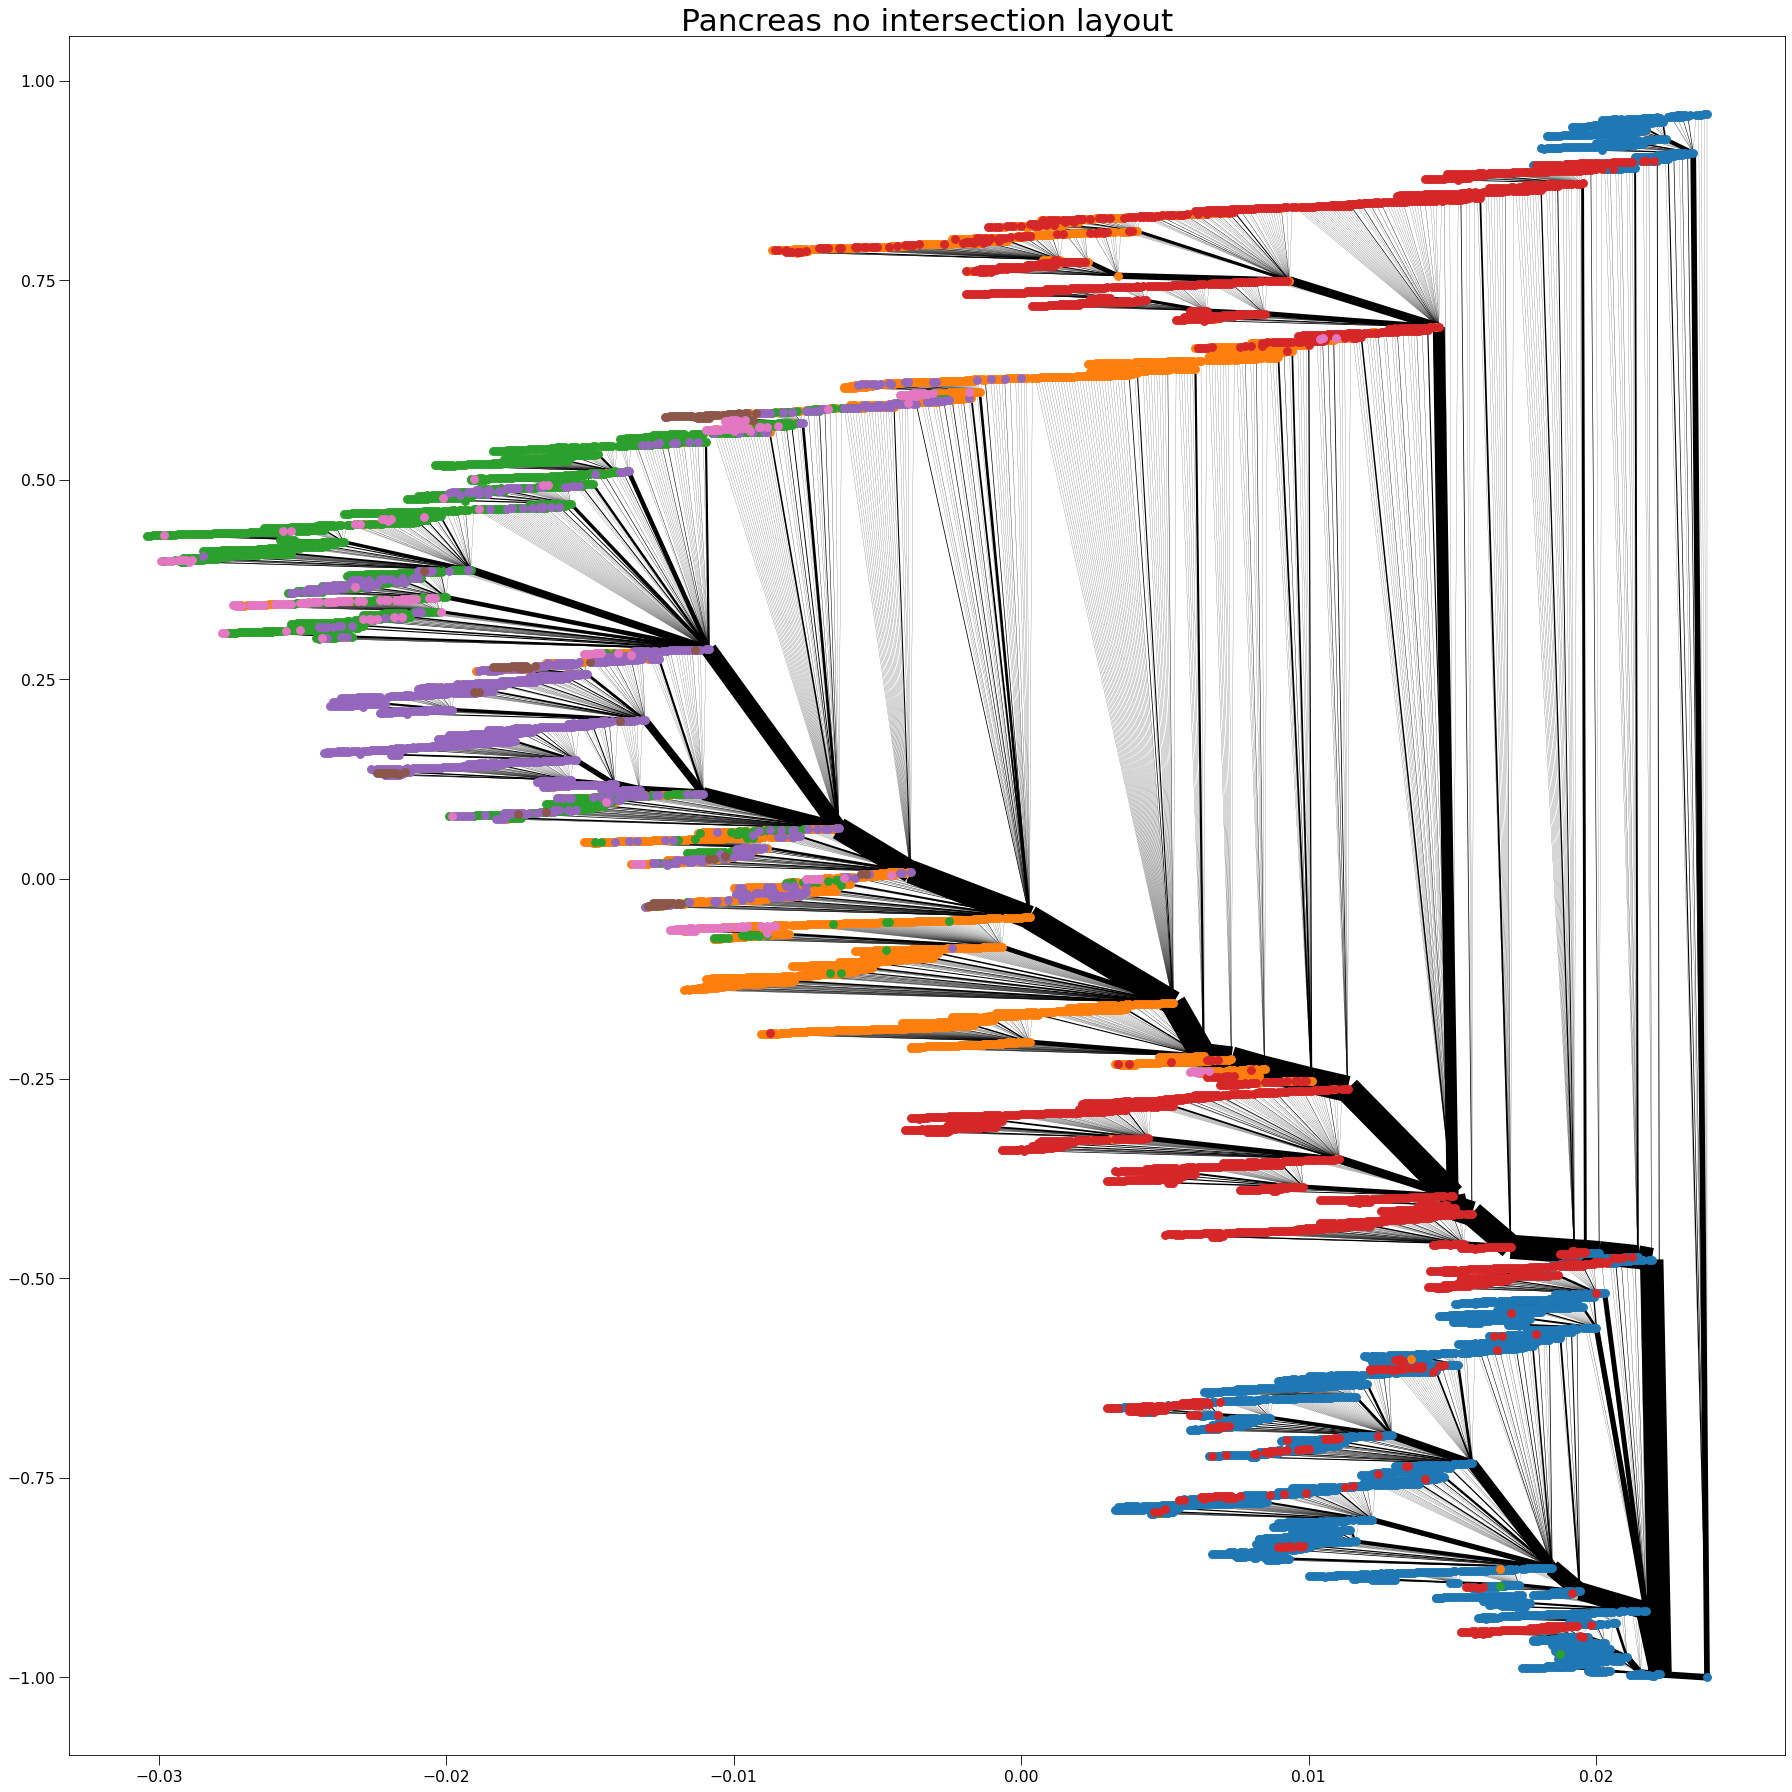

In [16]:
import networkx as nx
from copy import deepcopy
from numpy.linalg import norm
ICT = deepcopy(ICT_cluster_all)

for u, v in ICT.iterEdges():
    ICT.setWeight(u, v, norm(position[u] - position[v]))
    
ICT_nx = nk.nxadapter.nk2nx(ICT)

def arr_to_dict(arr):
    dct = {}
    for idx, elem in tqdm(enumerate(arr), desc="Create a dict from the position array"):
        dct[idx] = elem
    return dct

mapping = nx.planar_layout(ICT_nx)

mapping_ndarray = np.zeros((ICT.upperEdgeIdBound()+1,2))

# print(mapping_ndarray)

for key, val in zip(mapping.keys(), mapping.values()):
#     print(key)
    mapping_ndarray[key] = np.array([-val[1], -val[0]])
    
mapping = mapping_ndarray

# plotting
graphs = [ICT_cluster_all]
widths = [widths_cluster_all]
names = ["Pancreas no intersection layout", "Empty dataset"]


number_of_plots = 1
fig, ax = plt.subplots(1,1, figsize=(24,24))

if number_of_plots == 1:
    ax = [ax]
    
for i in range(number_of_plots):
    if i == 0:
        nk.viztasks.drawGraph(graphs[i], pos=mapping, ax=ax[i], width=np.array(widths[i])**1.3, node_size=0)
        ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#         ax[i].plot(*mapping[cluster_centers].T, marker="o", color = "Red")
        ax[i].set_axis_on()
        for label in unique_labels:
            plt.plot(*mapping[np.argwhere(labels == label).T[0]].T, label=label)
    ax[i].set_title(names[i])
#     ax[i].axis("equal")
    
plt.tight_layout()
plt.savefig("./Output/Images/pancreas-11-1_25-no-intersections")
plt.show()